This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting readmission using pytorch library.
* The logistic regression model has the architecture of an embedding layer, a linear activation and sigmoid transformation.
* Our model currently achieves around 0.81 test accuracy.
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end.

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random
import pandas as pd
import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle
    
import operator
from functools import reduce 

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model_em as model #here the em experiment
import Loaddata as Loaddata
import TrainVaTe_em as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda
torch.cuda.set_device(0)

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=np.exp(-7.8810), help='initial learning rate [default: 0.0004]')
parser.add_argument('-L2', type=float, default=np.exp(-5.8401), help='L2 regularization [default: 0.003]')
parser.add_argument('-epochs', type=int, default=20, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=128, help='number of embedding dimension [default: 128]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='comma-separated kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = np.exp(-7.8810)
args.L2 = np.exp(-5.8401)
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
#args.seq_file = 'Data/h143.visits'
#args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
def data_load_split_VT(folder = 'data2/cerner/unbalanced_data/hf50_all', hosp_list=['test','train','valid'], test_r=0.2 , valid_r=0.1):

   merged_set=[]
   for h in hosp_list:
       seqFile= folder+'.visitsNN.'+h
       labelFile= folder+'.labels.'+h
       set_x = pickle.load(open(seqFile, 'rb'), encoding='bytes')
       set_y = pickle.load(open(labelFile, 'rb'),encoding='bytes')
       merged_set_h = [[set_y[i],set_x[i]] for i in range(len(set_y))] # merge the two lists
       #merged_set_h_f = [[set_y[i],set_x[i][:-1]] for i in range(len(set_x))] # added [:-1] to exclude last visit
       #merged_set_h =[x for x in merged_set_f if len(x[1])>0]
       
       merged_set.extend(merged_set_h)

   #print (set_y[1],set_x[1][:-1], len(set_x[1][:-1]))

   # set random seed
   random.seed( 3 )

   dataSize = len(merged_set)
   nTest = int(test_r * dataSize)
   nValid = int(valid_r * dataSize)

   random.shuffle(merged_set)

   test_set = merged_set[:nTest]
   valid_set = merged_set[nTest:nTest+nValid]
   train_set = merged_set[nTest+nValid:]

   return train_set, valid_set, test_set

In [14]:
train1 , valid1, test1 = data_load_split_VT()
test_sh_L =[x for x in test1 if len(x[1])< 5]
test_l_L = [x for x in test1 if x not in test_sh_L]
print (len(train1),len(valid1),len(test1))

KeyboardInterrupt: 

In [ ]:
train1[0]

In [15]:
#to reload:
train1 = pickle.load(open('hf50_unb_train', 'rb'), encoding='bytes')
valid1 = pickle.load(open('hf50_unb_valid', 'rb'), encoding='bytes')
test1= pickle.load(open('hf50_unb_test', 'rb'), encoding='bytes')
test_sh_L =[x for x in test1 if len(x[1])< 5]
test_l_L = [x for x in test1 if x not in test_sh_L]
print (len(train1),len(valid1),len(test1))#### 346171 49452 98905 

346171 49452 98905


In [16]:
train1[0]

[0,
 [[16067,
   15091,
   16072,
   11765,
   14458,
   12611,
   16078,
   4750,
   12066,
   652,
   857,
   7258,
   1201,
   1196],
  [15091, 14458],
  [16067, 16072, 11765, 3822, 16078, 4750, 12026, 2910, 1201, 1196],
  [16067,
   16072,
   11765,
   15499,
   14475,
   11857,
   11892,
   11893,
   2691,
   16078,
   13913,
   11756,
   2361,
   1201,
   1196],
  [16067, 15091, 16072, 11765, 14458, 7592, 3822, 16078, 12026, 1201]]]

In [17]:
# load and prepare data
#set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
#set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
"""
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit]) 
"""
#model_x = set_x     

#merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
#train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)

#further processing training, valid, test data format, for the visits information merged into one huge list 

#split the test data according to length
#test_sh_L =[x for x in test1 if len(x[1])< 5]
#test_l_L = [x for x in test1 if x not in test_sh_L]
#print(test_sh_L[0])
#print(test_l_L[0])

train1 = [[train1[i][0],reduce(operator.concat, train1[i][1])] for i in range(len(train1))]
valid1 = [[valid1[i][0],reduce(operator.concat, valid1[i][1])] for i in range(len(valid1))]
test1 = [[test1[i][0],reduce(operator.concat, test1[i][1])] for i in range(len(test1))]
test_sh_L = [[test_sh_L[i][0],reduce(operator.concat, test_sh_L[i][1])] for i in range(len(test_sh_L))]
test_l_L = [[test_l_L[i][0],reduce(operator.concat, test_l_L[i][1])] for i in range(len(test_l_L))]
print('-' * 120)
print('\nAfter flatten:')
print(train1[0])
print(test_sh_L[0])
print(test_l_L[0])


Loading and preparing data...

Sample data after split:
[0, [[16067, 15091, 16072, 11765, 14458, 12611, 16078, 4750, 12066, 652, 857, 7258, 1201, 1196], [15091, 14458], [16067, 16072, 11765, 3822, 16078, 4750, 12026, 2910, 1201, 1196], [16067, 16072, 11765, 15499, 14475, 11857, 11892, 11893, 2691, 16078, 13913, 11756, 2361, 1201, 1196], [16067, 15091, 16072, 11765, 14458, 7592, 3822, 16078, 12026, 1201]]]
model is LR
------------------------------------------------------------------------------------------------------------------------

After flatten:
[0, [16067, 15091, 16072, 11765, 14458, 12611, 16078, 4750, 12066, 652, 857, 7258, 1201, 1196, 15091, 14458, 16067, 16072, 11765, 3822, 16078, 4750, 12026, 2910, 1201, 1196, 16067, 16072, 11765, 15499, 14475, 11857, 11892, 11893, 2691, 16078, 13913, 11756, 2361, 1201, 1196, 16067, 15091, 16072, 11765, 14458, 7592, 3822, 16078, 12026, 1201]]
[1, [5316, 14454, 15497, 15478, 14763, 14625, 16071, 14815, 15135, 13854, 16078, 15006, 14488, 541

Parameter containing:
 1.2650e+00  1.0818e+00
-8.5733e-01 -9.0044e-01
 1.0541e+00 -2.6639e-02
           ⋮            
 6.3036e-01 -1.0190e+00
 1.1067e+00  2.0151e+00
 1.5915e+00  1.5428e+00
[torch.FloatTensor of size 20000x2]

15815
      emb_0     emb_1                           types
0  1.264976  1.081786                            Code
1 -0.857332 -0.900439  b'M_ACETAMINOPHEN-HYDROCODONE'
2  1.054138 -0.026639         b'M_BACITRACIN TOPICAL'
3 -0.741144  0.724886    b'M_BUPIVACAINE-EPINEPHRINE'
4 -0.444115  0.772939                  b'M_CEFAZOLIN'


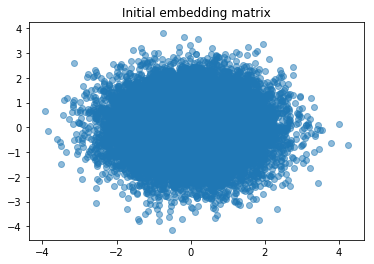

In [18]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

In [19]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep = []
test_sh_auc_allep=[]
test_l_auc_allep=[]

In [20]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 0.364291753075378


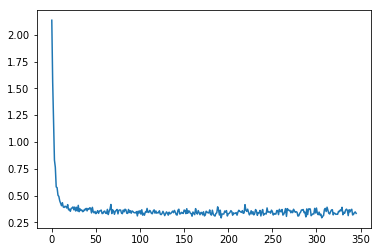

Epoch  0 Summary:  Training_auc : 0.7624329810212659  , Validation_auc :  0.762882223556143  ,Test_auc :  0.7590012677501455 Test_auc on short visits: 0.746838789194795 Test_auc on long visits: 0.7764594319566969  Avg Loss:  0.364291753075378 Train Time (9m 21s) Eval Time (8m 14s)


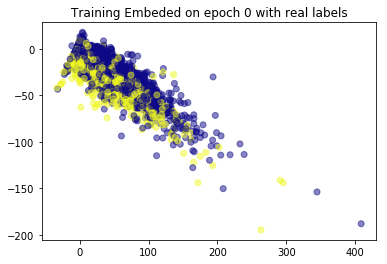

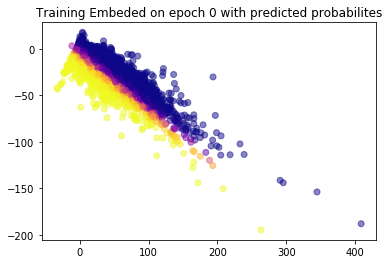


 Current running on: Epoch  1 Training loss:  Average loss 0.34255881262099214


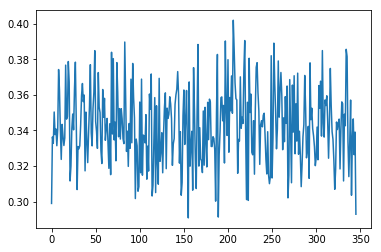

Epoch  1 Summary:  Training_auc : 0.7523061441220689  , Validation_auc :  0.74922695878282  ,Test_auc :  0.7490894563824475 Test_auc on short visits: 0.7392273404509772 Test_auc on long visits: 0.7673960010275702  Avg Loss:  0.34255881262099214 Train Time (8m 56s) Eval Time (9m 11s)


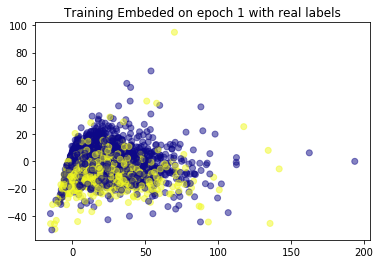

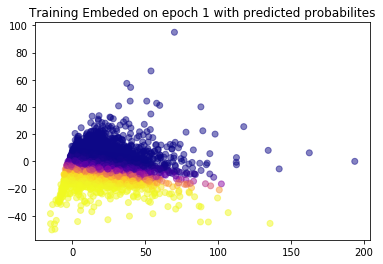


 Current running on: Epoch  2 Training loss:  Average loss 0.34181822400875056


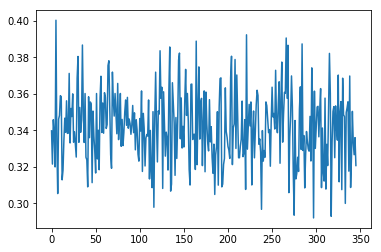

Epoch  2 Summary:  Training_auc : 0.7497103683053714  , Validation_auc :  0.7451540728147222  ,Test_auc :  0.7446832676559968 Test_auc on short visits: 0.7437179468463337 Test_auc on long visits: 0.760192492803643  Avg Loss:  0.34181822400875056 Train Time (8m 4s) Eval Time (9m 4s)


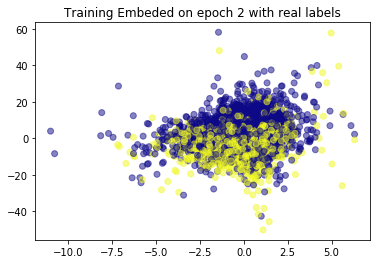

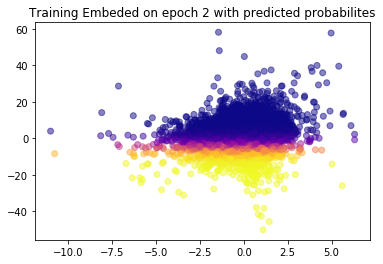


 Current running on: Epoch  3 Training loss:  Average loss 0.3413122422725954


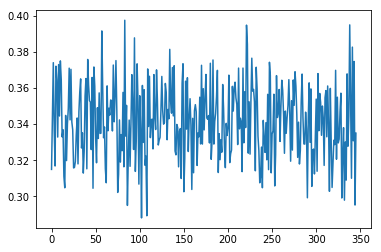

Epoch  3 Summary:  Training_auc : 0.765013104484882  , Validation_auc :  0.763248348861676  ,Test_auc :  0.761089086325739 Test_auc on short visits: 0.7497370368962384 Test_auc on long visits: 0.7787843200930433  Avg Loss:  0.3413122422725954 Train Time (9m 4s) Eval Time (9m 5s)


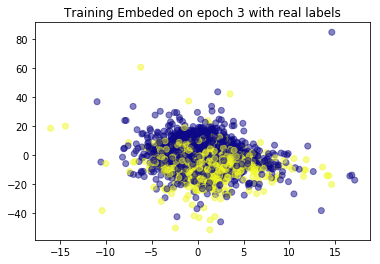

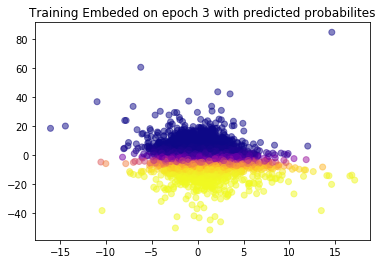


 Current running on: Epoch  4 Training loss:  Average loss 0.3417572028962783


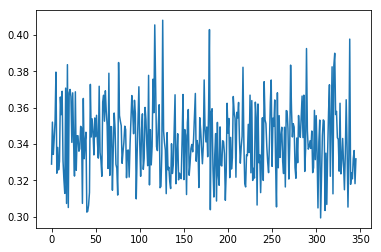

Epoch  4 Summary:  Training_auc : 0.7662725367440641  , Validation_auc :  0.7648401969592279  ,Test_auc :  0.7615314936608472 Test_auc on short visits: 0.7436994963557974 Test_auc on long visits: 0.7823115863887806  Avg Loss:  0.3417572028962783 Train Time (9m 7s) Eval Time (8m 51s)


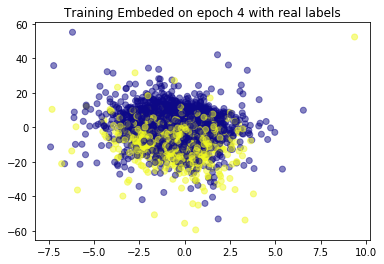

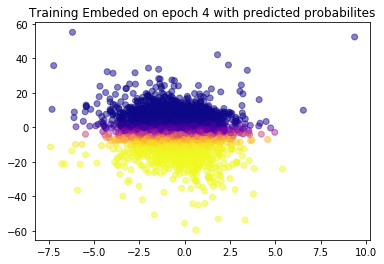


 Current running on: Epoch  5 Training loss:  Average loss 0.34144472556090283


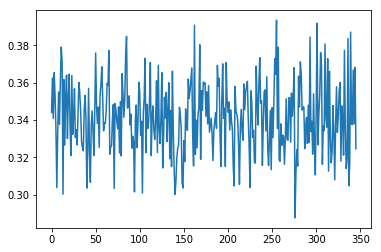

Epoch  5 Summary:  Training_auc : 0.7552128189353492  , Validation_auc :  0.7508394812765573  ,Test_auc :  0.7509243282374437 Test_auc on short visits: 0.748418619587252 Test_auc on long visits: 0.7655971034960348  Avg Loss:  0.34144472556090283 Train Time (8m 2s) Eval Time (8m 5s)


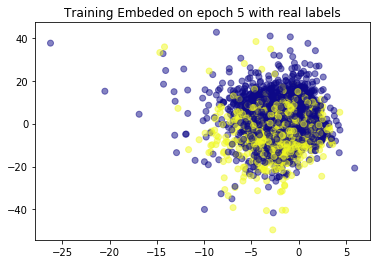

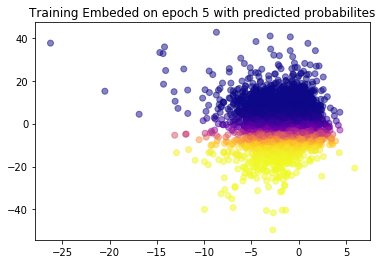


 Current running on: Epoch  6 Training loss:  Average loss 0.34142551609071053


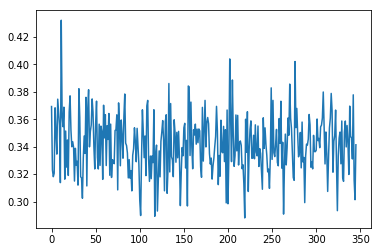

Epoch  6 Summary:  Training_auc : 0.7544395054938882  , Validation_auc :  0.7510894309117012  ,Test_auc :  0.748389610551061 Test_auc on short visits: 0.7448132430571873 Test_auc on long visits: 0.7636981156733234  Avg Loss:  0.34142551609071053 Train Time (8m 31s) Eval Time (7m 22s)


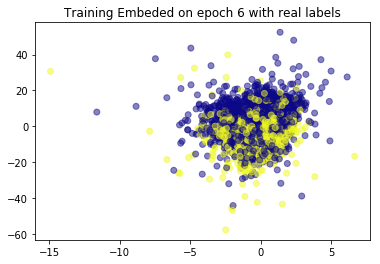

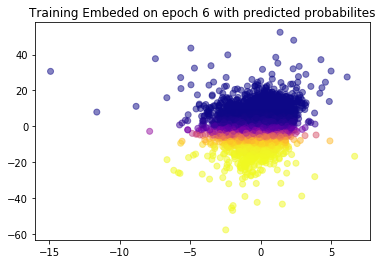


 Current running on: Epoch  7 Training loss:  Average loss 0.341321073639942


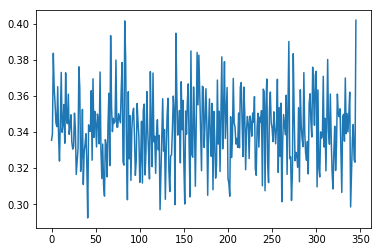

Epoch  7 Summary:  Training_auc : 0.7606997475174506  , Validation_auc :  0.7588977049239848  ,Test_auc :  0.7567425048918834 Test_auc on short visits: 0.7455850944960299 Test_auc on long visits: 0.7749660707399011  Avg Loss:  0.341321073639942 Train Time (9m 1s) Eval Time (9m 16s)


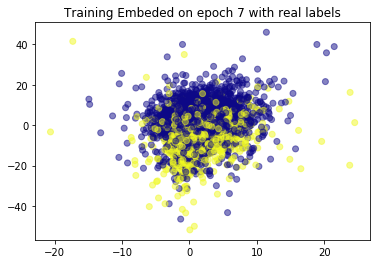

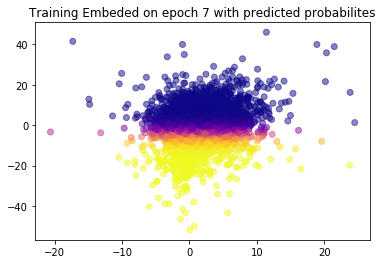


 Current running on: Epoch  8 Training loss:  Average loss 0.34140413186338675


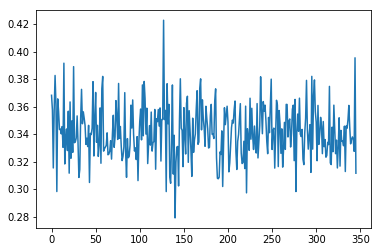

Epoch  8 Summary:  Training_auc : 0.7595357885617695  , Validation_auc :  0.7573387832707199  ,Test_auc :  0.7556483964375815 Test_auc on short visits: 0.7477147822359821 Test_auc on long visits: 0.7723054374323335  Avg Loss:  0.34140413186338675 Train Time (8m 19s) Eval Time (9m 37s)


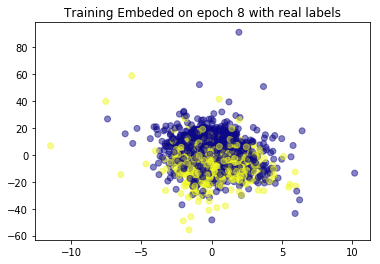

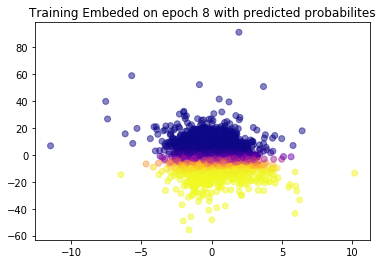


 Current running on: Epoch  9 Training loss:  Average loss 0.34149678794641597


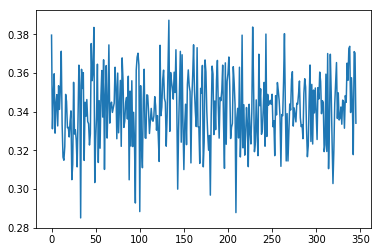

Epoch  9 Summary:  Training_auc : 0.7626914005819172  , Validation_auc :  0.7592918087313023  ,Test_auc :  0.7570551919947258 Test_auc on short visits: 0.7432509291290954 Test_auc on long visits: 0.7758964401935121  Avg Loss:  0.34149678794641597 Train Time (8m 19s) Eval Time (9m 13s)


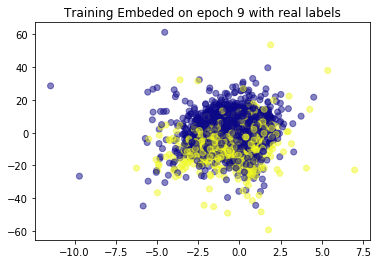

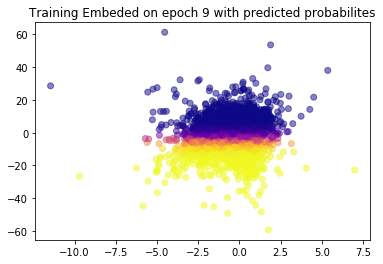


 Current running on: Epoch  10 Training loss:  Average loss 0.3413269881241042


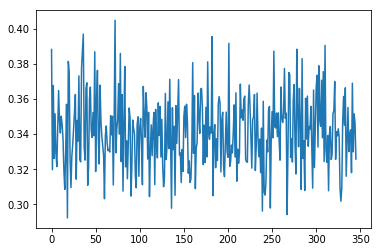

Epoch  10 Summary:  Training_auc : 0.7586308769661201  , Validation_auc :  0.7567243987835661  ,Test_auc :  0.7546785210792439 Test_auc on short visits: 0.744950444554465 Test_auc on long visits: 0.7713935568308685  Avg Loss:  0.3413269881241042 Train Time (9m 5s) Eval Time (9m 0s)


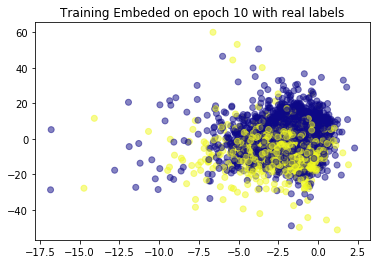

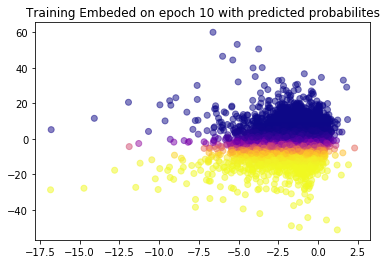


 Current running on: Epoch  11 Training loss:  Average loss 0.34137767771922545


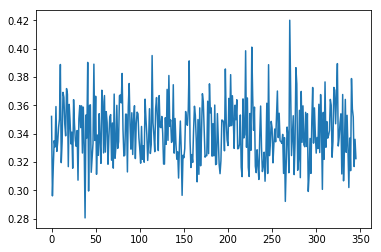

Epoch  11 Summary:  Training_auc : 0.7292990298393338  , Validation_auc :  0.7259886588445518  ,Test_auc :  0.725716444688158 Test_auc on short visits: 0.7407308802032915 Test_auc on long visits: 0.7427127665699975  Avg Loss:  0.34137767771922545 Train Time (9m 16s) Eval Time (9m 9s)


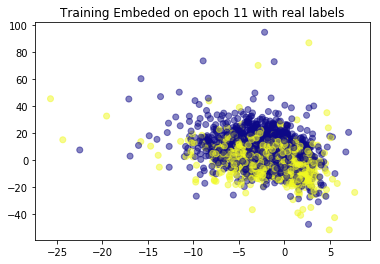

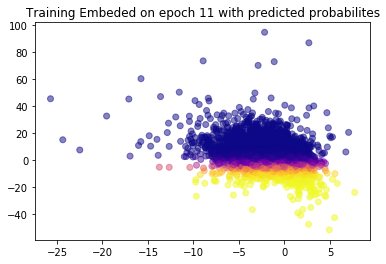


 Current running on: Epoch  12 Training loss:  Average loss 0.3415517523953674


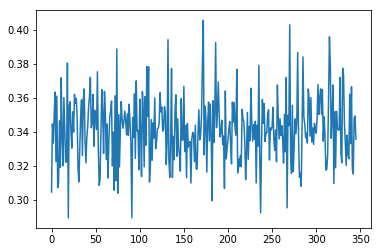

Epoch  12 Summary:  Training_auc : 0.7490100405122457  , Validation_auc :  0.7438201329476621  ,Test_auc :  0.7439901301990364 Test_auc on short visits: 0.7424788877973287 Test_auc on long visits: 0.75897121065487  Avg Loss:  0.3415517523953674 Train Time (9m 24s) Eval Time (9m 22s)


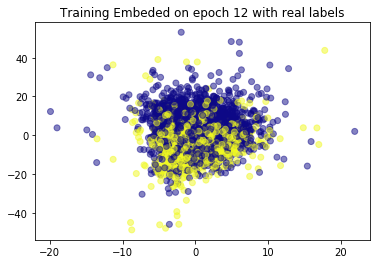

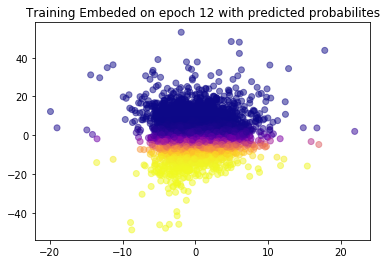


 Current running on: Epoch  13 Training loss:  Average loss 0.34140416690796166


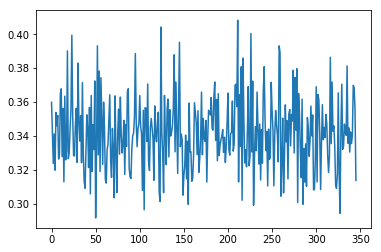

Epoch  13 Summary:  Training_auc : 0.7544483340637884  , Validation_auc :  0.7524930327976744  ,Test_auc :  0.7510403575749238 Test_auc on short visits: 0.7437332772263041 Test_auc on long visits: 0.770393099546649  Avg Loss:  0.34140416690796166 Train Time (9m 28s) Eval Time (9m 10s)


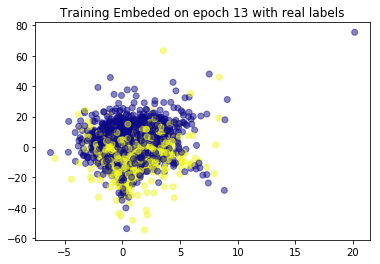

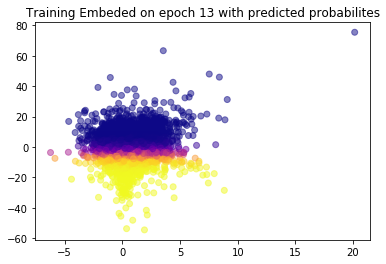


 Current running on: Epoch  14 Training loss:  Average loss 0.34117566468352023


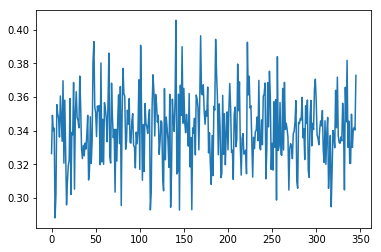

Epoch  14 Summary:  Training_auc : 0.7638455525114619  , Validation_auc :  0.7619380884337348  ,Test_auc :  0.7596219542946786 Test_auc on short visits: 0.7480753286889044 Test_auc on long visits: 0.7774214996009408  Avg Loss:  0.34117566468352023 Train Time (8m 42s) Eval Time (9m 25s)


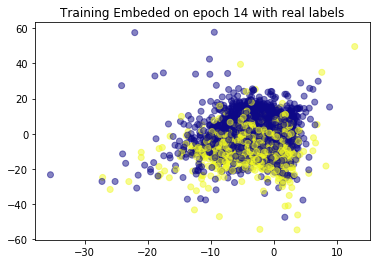

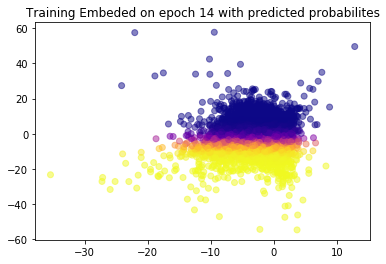


 Current running on: Epoch  15 Training loss:  Average loss 0.3416325485614527


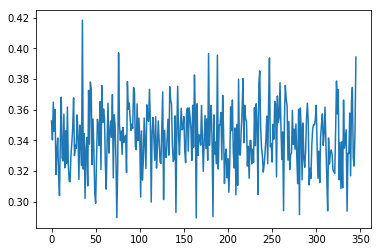

Epoch  15 Summary:  Training_auc : 0.7657623097795737  , Validation_auc :  0.7630400939634852  ,Test_auc :  0.7617516806453195 Test_auc on short visits: 0.7481211932335328 Test_auc on long visits: 0.7805587573633794  Avg Loss:  0.3416325485614527 Train Time (8m 37s) Eval Time (8m 46s)


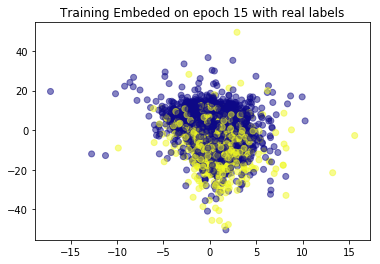

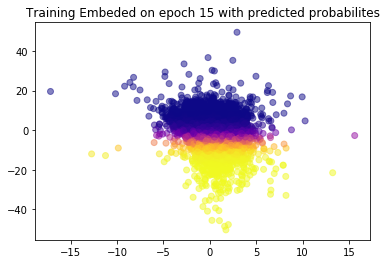


 Current running on: Epoch  16 Training loss:  Average loss 0.3416031705942677


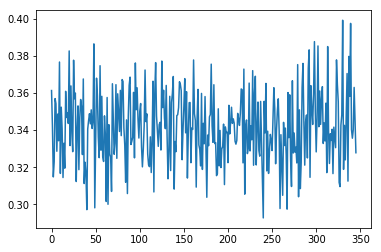

Epoch  16 Summary:  Training_auc : 0.7641551304696659  , Validation_auc :  0.7610622633414155  ,Test_auc :  0.7585241502594668 Test_auc on short visits: 0.7458088454828864 Test_auc on long visits: 0.7771462190508449  Avg Loss:  0.3416031705942677 Train Time (9m 16s) Eval Time (9m 10s)


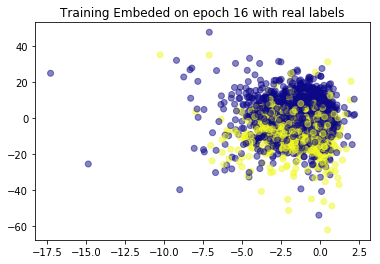

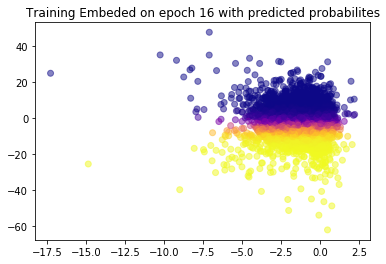


 Current running on: Epoch  17 Training loss:  Average loss 0.3412420805321328


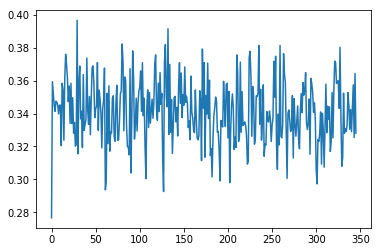

Epoch  17 Summary:  Training_auc : 0.7562049087696988  , Validation_auc :  0.755059242224214  ,Test_auc :  0.7529485018428971 Test_auc on short visits: 0.7410893115886853 Test_auc on long visits: 0.7722541222482529  Avg Loss:  0.3412420805321328 Train Time (8m 44s) Eval Time (9m 24s)


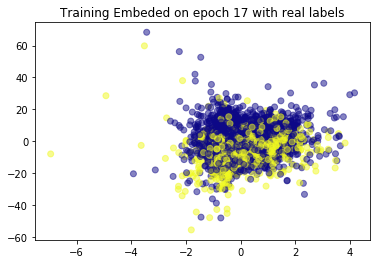

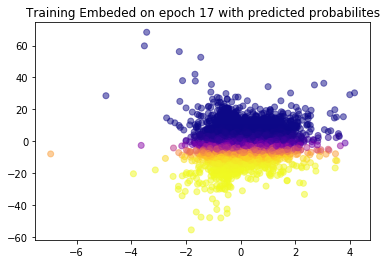


 Current running on: Epoch  18 Training loss:  Average loss 0.34153598022903786


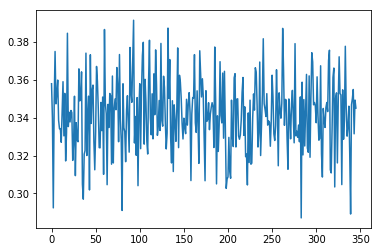

Epoch  18 Summary:  Training_auc : 0.7521251652700907  , Validation_auc :  0.7469908590259112  ,Test_auc :  0.7474687866953118 Test_auc on short visits: 0.7461435587789061 Test_auc on long visits: 0.7634690373176242  Avg Loss:  0.34153598022903786 Train Time (8m 17s) Eval Time (9m 18s)


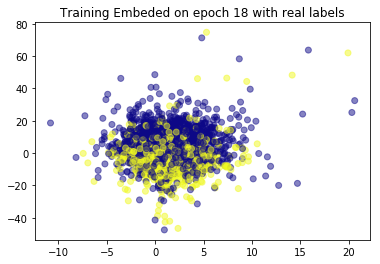

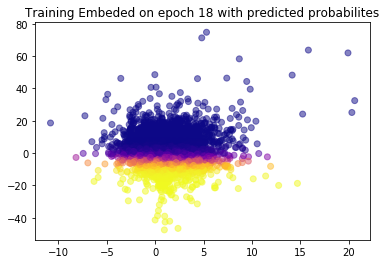


 Current running on: Epoch  19 Training loss:  Average loss 0.34169346380262144


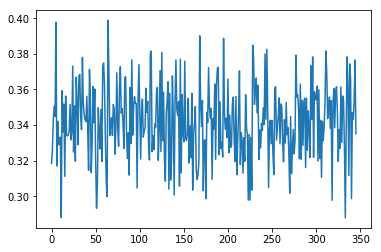

Epoch  19 Summary:  Training_auc : 0.7620467114275411  , Validation_auc :  0.7629421486375616  ,Test_auc :  0.7583240143554395 Test_auc on short visits: 0.7456771632311672 Test_auc on long visits: 0.7772151130687243  Avg Loss:  0.34169346380262144 Train Time (8m 33s) Eval Time (9m 18s)


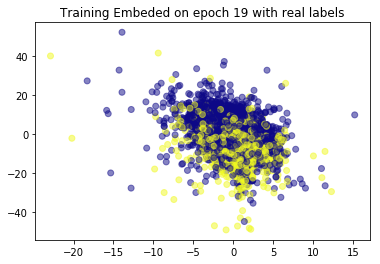

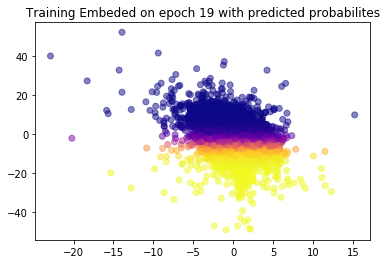

In [21]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss, em = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    #print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat, emb = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    #TVT.auc_plot(y_real, y_hat)
    valid_auc, _, _, _  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    #TVT.auc_plot(y_real, y_hat)
    test_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    shorttest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_sh_L, which_model = args.which_model, batch_size = args.batch_size)
    longtest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_l_L, which_model = args.which_model, batch_size = args.batch_size) 
    #print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    #TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,Test_auc : " , test_auc, 
           "Test_auc on short visits:",shorttest_auc, "Test_auc on long visits:", longtest_auc," Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    test_sh_auc_allep.append(shorttest_auc)
    test_l_auc_allep.append(longtest_auc)
  
    color1 = np.array([item for item in y_real])
    plt.figure()
    plt.scatter(emb[1:,0],emb[1:,1], c= color1, cmap= 'plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with real labels')
    plt.show()
    color2 = np.array([item for item in y_hat])
    plt.scatter(emb[1:,0],emb[1:,1], c= color2, cmap='plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with predicted probabilites')
    plt.show()

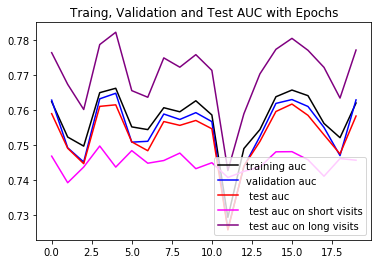

In [22]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.plot(test_sh_auc_allep, color = 'magenta', label =' test auc on short visits')
plt.plot(test_l_auc_allep, color = 'purple', label =' test auc on long visits')
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.legend(loc= 'lower right')
plt.show()

In [23]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')
test_sh_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_sh_auc_allep, name ='Test auc on <5 visits)')
test_l_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_l_auc_allep, name ='Test auc on >=5 visits)')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg, valid_auc_fg, test_auc_fg, test_sh_auc_fg, test_l_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_dim2_biggestdata_unbalanced')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')